In [1]:
import pandas as pd

# shot_list_sheet_1 = pd.read_excel("./dataset/KSTAR_Disruption_Shot_List.csv", sheet_name = 'Sheet1')
# shot_list_sheet_2 = pd.read_excel("./dataset/KSTAR_Disruption_Shot_List.csv", sheet_name = 'Sheet2')
short_list_sheet = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List.csv")

In [2]:
short_list_sheet

,shot,year,tftsrt,tipminf,tTQend,Isdata
0,12350,2015,1.500,5.246,5.2248,NaN
1,12372,2015,0.700,3.818,3.8026,NaN
2,12415,2015,1.900,4.769,4.7450,NaN
3,12438,2015,1.100,3.702,3.6826,NaN
4,12481,2015,1.900,5.217,5.1923,NaN
...,...,...,...,...,...,...
1091,21730,2018,1.500,4.968,4.9490,NaN
1092,21731,2018,1.500,4.913,4.8950,NaN
1093,21735,2018,1.500,89.746,89.7320,NaN
1094,21747,2018,3.724,11.451,11.4190,NaN


In [3]:

from src.dataloader import VideoDataset
from torch.utils.data import DataLoader

batch_size = 4
clip_len = 10
train_data_dist10 = VideoDataset(dataset = "fast_model_dataset", split = "train", clip_len = clip_len, preprocess = False)
train_loader_dist10 = DataLoader(train_data_dist10, batch_size = batch_size, shuffle = True, num_workers = 4)


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of train videos: 1240


sample_img :  torch.Size([3, 112, 112])


/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/home/zinzinbin/.conda/envs/research-env/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


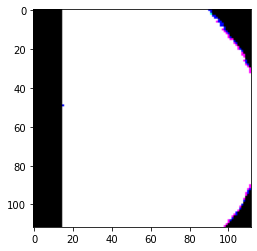

In [4]:
sample_data, sample_label = next(iter(train_loader_dist10))
sample_img = sample_data[0, :, 0, :, :]

print("sample_img : ", sample_img.size())

from src.utility import show_frame

show_frame(sample_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


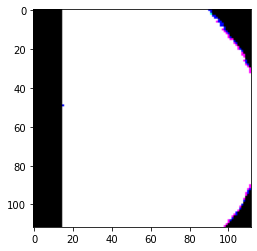

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


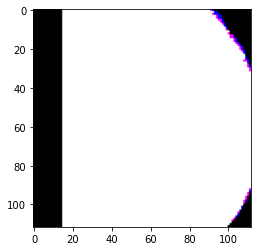

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


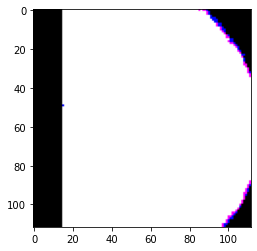

In [5]:
for idx in range(sample_data.size(1)):
    sample_img = sample_data[0, :, idx, :, :]
    show_frame(sample_img)

In [6]:
sample_data, sample_target = next(iter(train_loader_dist10))
print("sample data : ", sample_data.size())
print("sample target : ", sample_target.size())

sample data :  torch.Size([4, 3, 10, 112, 112])
sample target :  torch.Size([4])


In [7]:
from src.model import VideoSpatioEncoder

encoder = VideoSpatioEncoder(
    input_shape  = (3, 8, 112, 112),
    alpha  = 0.01,
)

In [8]:
sample_enc = encoder(sample_data)
print("sample_enc : ", sample_enc.size())

sample_enc :  torch.Size([4, 8, 23040])


In [9]:
from src.transformer import SBERT
sbert = SBERT(
    num_features = sample_enc.size(-1),
    hidden = 128,
    n_layers = 4,
    attn_heads = 8, 
    max_len  = 8
)

In [10]:
import torch

sample_doy = torch.tensor([[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]])
sample_mask = None

sample_sbert_output = sbert(sample_enc, sample_doy, sample_mask)

In [11]:
print("sbert output : ", sample_sbert_output.size())

sbert output :  torch.Size([4, 8, 128])


In [12]:
sample_doy = torch.IntTensor(list(map(int, range(1, 8 + 1)))).repeat(sample_enc.size(0), 1)
sample_mask = None
sample_sbert_output = sbert(sample_enc, sample_doy, sample_mask)
print("sbert output : ", sample_sbert_output.size())

sbert output :  torch.Size([4, 8, 128])


In [13]:
from src.model import SBERTDisruptionClassifier

model = SBERTDisruptionClassifier(
    spatio_encoder = encoder, 
    sbert = sbert, 
    mlp_hidden = 128, 
    num_classes = 2
)

In [14]:
model.sbert.num_features

23040

In [15]:
step1 = model.spatio_encoder(sample_data)
print(step1.size())

torch.Size([4, 8, 23040])


In [16]:
model.classifier

MulticlassClassifier(
  (pooling): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [17]:
from src.transformer import MulticlassClassifier

classifier = MulticlassClassifier(
    enc_dims = 128,
    hidden  = 128,
    num_classes=2
)

classifier(sample_sbert_output)

tensor([[ 0.0036,  0.5933],
        [-0.2116,  0.9344],
        [-0.1304, -0.2191],
        [ 0.0081,  0.3001]], grad_fn=<AddmmBackward0>)

In [18]:
model.forward(sample_data)

tensor([[-5.5793e-04,  9.1915e-01],
        [ 2.2302e-01,  5.6655e-01],
        [ 1.5748e-01,  2.8444e-01],
        [-4.5031e-01, -1.0393e-01]], grad_fn=<AddmmBackward0>)

In [19]:
from src.model import *

r21p = R2Plus1DClassifier(
        input_size  = (3, 8, 112, 112),
        num_classes = 2, 
        layer_sizes = [2,2,2,2], 
        pretrained = False, 
        alpha = 0.01
)

video_encoder = VideoSpatioEncoder(
    input_shape  = (3, 8, 112, 112),
    alpha  = 0.01,
)

temporal_encoder = SBERT(
    num_features = 18432,
    hidden = 128,
    n_layers = 4,
    attn_heads = 8, 
    max_len  = 8
)

sbert_model = SBERTDisruptionClassifier(
    spatio_encoder = video_encoder, 
    sbert = temporal_encoder, 
    mlp_hidden = 128, 
    num_classes = 2
)

TypeError: __init__() got an unexpected keyword argument 'STN_conv_channels'

In [ ]:
r21p.summary()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Parent Layers             Layer (type)             Input Shape         Param #     Tr. Param #
                                                 R2Plus1DClassifier/R2Plus1DNet/SpatioTemporalConv/Conv3dBlock                 Conv3d-1     [1, 3, 8, 112, 112]           6,615           6,615
                                                 R2Plus1DClassifier/R2Plus1DNet/SpatioTemporalConv/Conv3dBlock            BatchNorm3d-2      [1, 45, 8, 56, 56]              90              90
                                                 R2Plus1DClassifier/R2Plus1DNet/SpatioTemporalConv/Conv3dBlock              LeakyReLU-3      [1, 45, 8, 56, 56]               0               0
                                        

In [ ]:
sbert_model.summary()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                              Parent Layers             Layer (type)                                     Input Shape         Param #     Tr. Param #
    SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock/Conv3dBlock                 Conv3d-1                             [8, 3, 8, 112, 112]           1,728           1,728
    SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock/Conv3dBlock            BatchNorm3d-2                              [8, 64, 8, 56, 56]             128             128
    SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock/Conv3dBlock              LeakyReLU-3                              [8, 64, 8, 56, 56]               0               0
                SBERTDisruptionClassifier/VideoSpatioEncoder/Conv3dResBlock                 Con

In [20]:
from src.model import VideoSpatialEncoder

encoder = VideoSpatialEncoder(
    input_shape = (3, 10, 112, 112),
)

AttributeError: type object 'Bottleneck3D' has no attribute 'expansion'